## Data 620 - Project 1

Baron Curtin, Heither Geiger

## Introduction

For this project, we will be using data containing the networks of 10 different Facebook users (aka the "ego nodes"). This data will be downloaded from the Stanford Large Network Dataset Collection. The dataset is available here: https://snap.stanford.edu/data/ego-Facebook.html.

Here, each node ID represents a Facebook user.

For each of the 10 different networks (denoted by the ID of the user at the center of the network), we have the following files:

\*.edges - Each line will have two columns. The node IDs in column 1 and column 2 are connected to each other and to the ego node.

\*.circles - Each line will have an ID column (i.e. circle0, circle1, and so on), followed by anywhere from one to 100+ additional columns. The circles represent groups of users. Each node ID in every field of every line is connected to the ego node.

\*.featnames - Gives more info about which feature corresponds to each feature column. For example, "8 education;classes;id;anonymized feature 8" means that column 9 of the features file (with 0-based indexing) corresponds to an anonymized feature related to education (specifically, classes taken). 

\*.egofeat and \*.feat - For each feature explained in featnames, give whether the feature is true or false in each user for the ego node and all other nodes respectively.

In [1]:
# load libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import combinations

# additional jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# create a constant for debugging to reduce size of graph
DEBUG = False

## Data Loading/Parsing

In the following code cells, we will be loading the data into Python and preparing it to be visualized with NetworkX


In [2]:
fb_path = Path('../week3/facebook')
file_types = ('circles', 'edges', 'egofeat', 'feat', 'featnames')

# load all files into python dictionary by file type
# tuple in format (int(node), file_path)
files = {file_type: [(int(f.stem), f) for f in fb_path.glob(f'*.{file_type}')] 
         for file_type in file_types}

Now that all of the files are loaded, we need to create a function that will parse each file appropriately


### File Parsing Functions
The below functions are helper functions that will be called in the main function parse_file(). 
Each of them are specific to a single type of file and the idiosyncracies that go along with that file.

In [3]:
def circles_parser(lines='', **kwargs):
    # circles files are tab delimited
    info = [(int(kwargs['node']), int(n))
            for l in lines 
            for n in l.split('\t')[1:]
            if l != '']
    return info

def edges_parser(lines='', **kwargs):
    # edges files are separated by spaces
    info = [x for l in lines
            for x in combinations([*l.split(' '), kwargs['node']], 2)
            if l != '']
    return info

def egofeat_parser(lines='', **kwargs):
    # egofeat is separated by spaces
    info = [x for l in lines
            for x in l.split(' ')
            if l != '']
    return info

def feat_parser(lines='', **kwargs):
    # feat files are separated by spaces
    info = [l.split(' ') 
            for l in lines
            if l != '']
    return info

def featnames_parser(lines='', **kwargs):
    # featnames files are delimited by ;
    # we will only use the first index and the last index of the featurename
    # as there are inconsistencies in length
    info = [(l.split(';')[0], l.split(';')[-1])
            for l in lines
            if l != '']
    return info


# dictionary of file parsing functions for easy referencing later
# using a dictionary will serve as a 'case' function
file_parsers = {
    'circles': circles_parser,
    'edges': edges_parser,
    'egofeat': egofeat_parser,
    'feat': feat_parser,
    'featnames': featnames_parser
}

In [4]:
def parse_file(file_, node, file_type=''):
    # basic error handling to make sure all required arguments are passed
    if (file_ is None) | (node == '') | (file_type == ''):
        raise ValueError('Unable to parse file without the required information')
    
    # get contents of the file
    content = file_.read_text()
    lines = content.split('\n')
    
    # reduce size of lines base on debug
    if DEBUG & (file_type in ['circles', 'edges']):
        lines = lines[:20] if len(lines) > 20 else lines
    
    # parse based on file type
    info = file_parsers[file_type](lines, node=node)
    return info

In [5]:
# we can use our created functions to create a new dictionary of parsed files
parsed_files = {file_type: {node: parse_file(file_path, node, file_type)
                            for node, file_path in list_of_nodes_files}
                for file_type, list_of_nodes_files in files.items()}

### Parsing the Categorical Feature (Gender)

Each "ego node" has a file with a ".feat" extension. The ".featnames" file maps the columns in the ".feat" file with the column name.
We will only take the columns given a distinction for gender from each ".feat" file.

In [12]:
# gather all the feature (column) names by node
feature_names = {int(node): ['_'.join(c) for c in cols]
                 for node, cols in parsed_files['featnames'].items()}

# create pandas dataframes for all nodes and relevant metrics
feature_dfs = {node: pd.DataFrame(data=data, columns=['node', *feature_names[node]])
               for node, data in parsed_files['feat'].items()}

# remove unnecessary columns (keep gender columns)
feature_dfs = {node: df.loc[:, ['node', *[col for col in df.columns
                                if 'gender' in col]]]
               for node, df in feature_dfs.items()}

# create gender1 and gender2 classification
for node, df in feature_dfs.items():
    # get first column that matches feature 78
    gender_col = next(col for col in df.columns if 'feature 78' in col)
    
    # use np.select for column creation
    conditions = [df[gender_col].astype('int32') == 0, 
                  df[gender_col].astype('int32') == 1,
                  df[gender_col].astype('int32') == np.nan]
    choices = ['gender1', 'gender2', 'gender0']
    df['gender_class'] = np.select(conditions, choices, default='null')
    
    # set attributes in node: gender_class form
    df['node'] = df['node'].astype('int32')
    feature_dfs[node] = df.set_index('node')['gender_class'].to_dict()

## Graph Construction
In the follow cells, we will be construct the network graph, adding edges, and adding the attributes.
Adding the attributes will allow us to easily extract that information from the .Nodes method of NetworkX and put 
that information into a Pandas dataframe.

In [13]:
g = nx.Graph()

# add edges from all the edges files
g.add_edges_from([y for x in parsed_files['circles'].values()
                  for y in x])

# add edges from all the circles files
g.add_edges_from([y for x in parsed_files['edges'].values()
                  for y in x])

# set node attributes
for features in feature_dfs.values():
    nx.set_node_attributes(g, features, 'gender')

<Figure size 3600x1440 with 0 Axes>

/Users/baron.curtin/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(-1.0803369184986484,
 0.6803369423405063,
 -0.7973599836882221,
 0.7158246443327535)

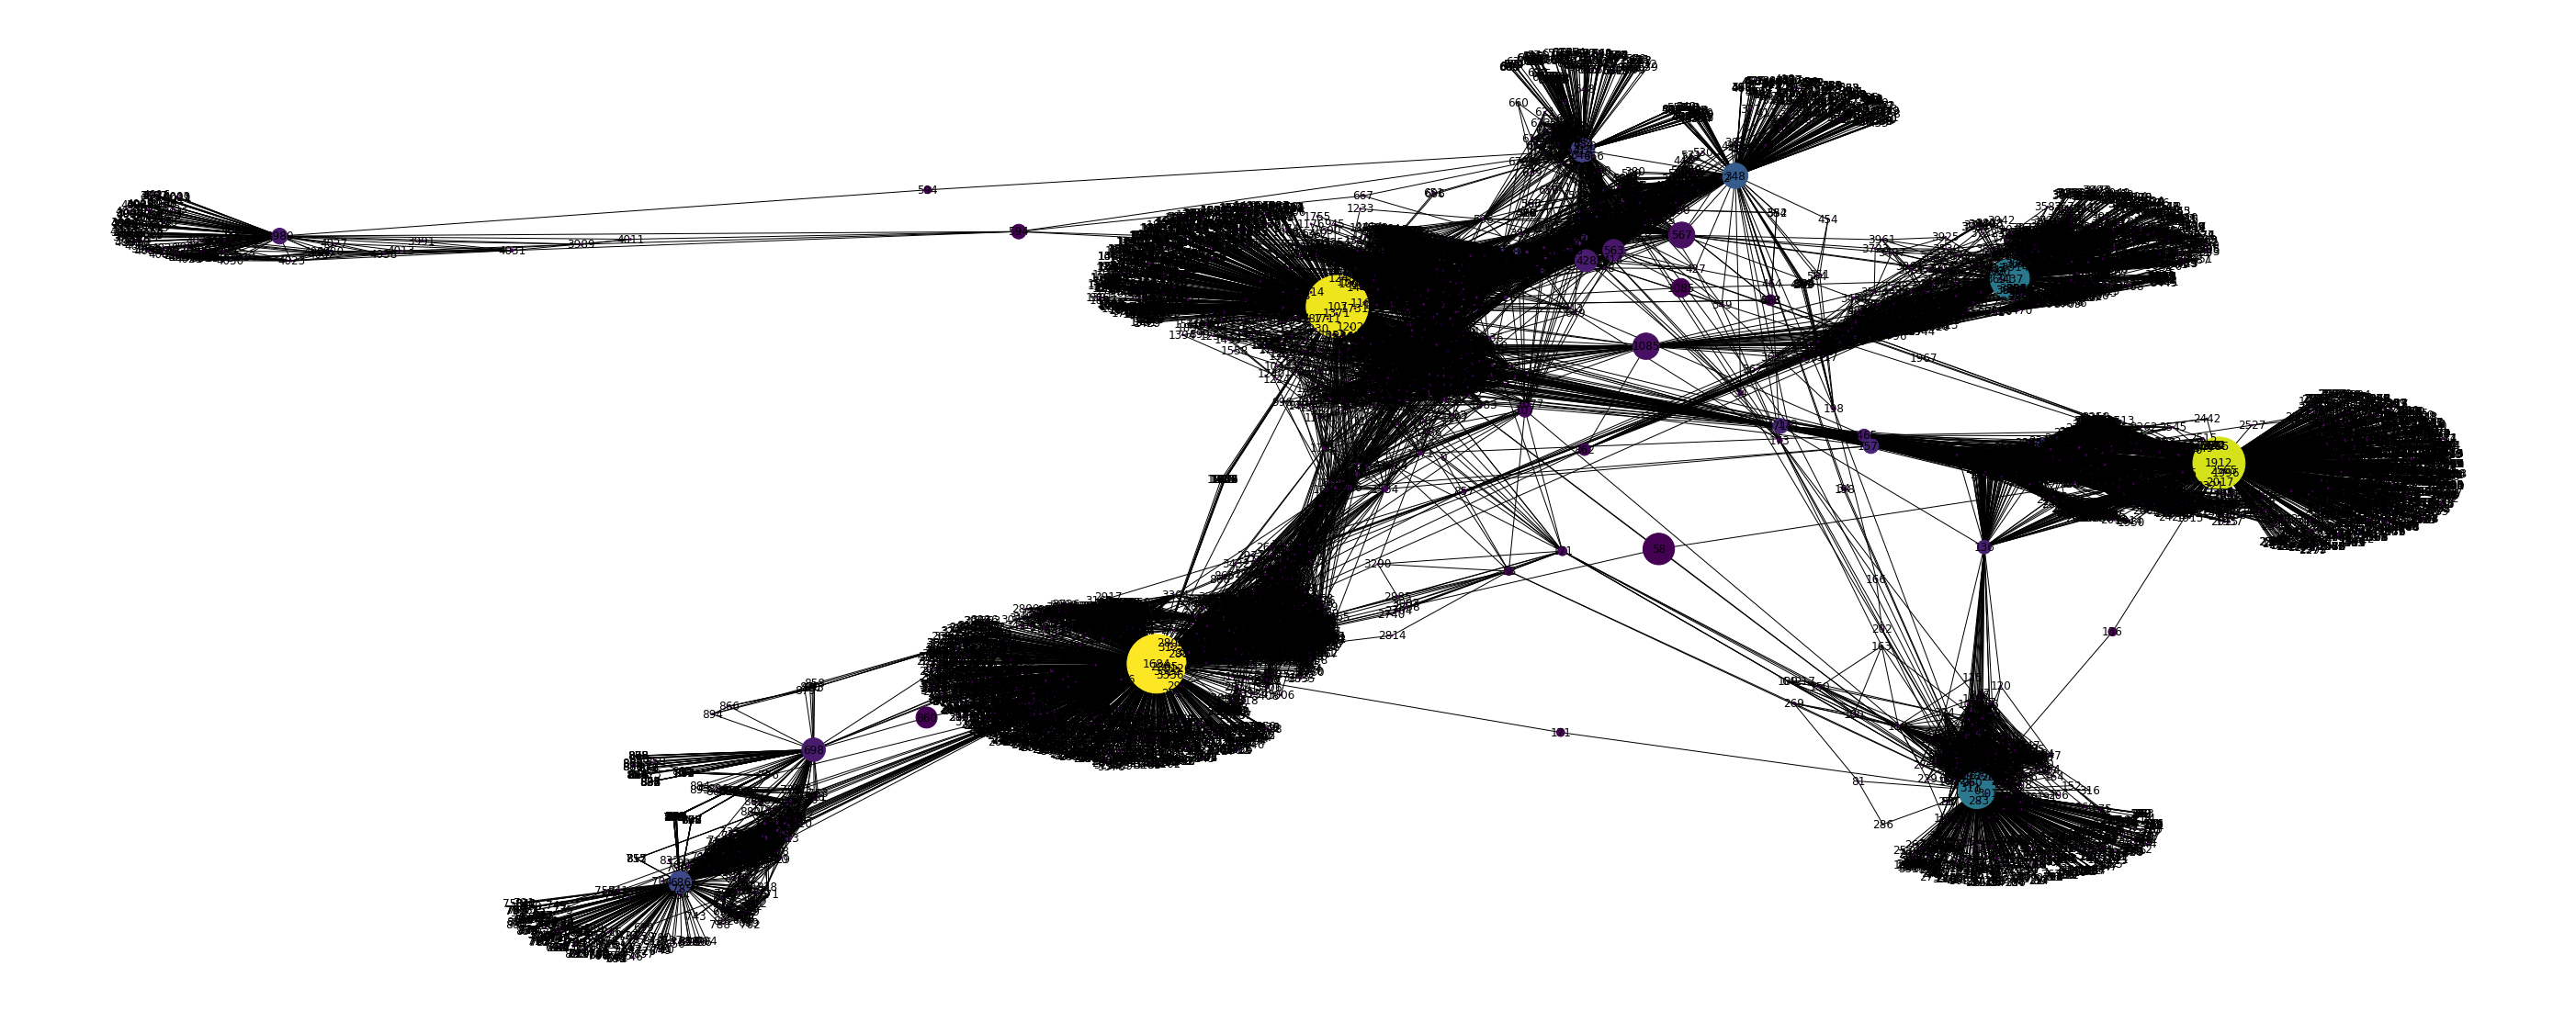

In [14]:
# preliminary color, size, pos setup for graph
pos = nx.spring_layout(g)
bet_centrality = nx.betweenness_centrality(g, normalized=True, endpoints=True)
node_color = [10000.0 * g.degree(v) for v in g]
node_size = [v * 10000.0 for v in bet_centrality.values()]

plt.figure(figsize=(50,20))
nx.draw_networkx(g, pos=pos, node_color=node_color, node_size=node_size)
plt.axis('off')

## Network Analysis

In the following cells we will calculate the degree centrality and eigenvector centrality and compare the centrality measures across nodes


### Dataframe Creation

First we will calculate the centrality measures and the pass them, along with the gender information to the Pandas dataframe constructor.
This will allow for easier data analysis afterwards as we can easily manipulate across nodes and categorical variables.
The hard part with this dataset is that so many of the attributes are anonymized.

In [15]:
# calculate degree centrality and eigenvector ventrality
degree_centrality = nx.degree_centrality(g)
eigen_centrality = nx.eigenvector_centrality(g)

# assign attributes to the nodes
nx.set_node_attributes(g, degree_centrality, 'degree_centrality')
nx.set_node_attributes(g, eigen_centrality, 'eigenvector_centrality')

In [16]:
# convert graph data from nodes to a list of dictionaries to pass to pandas constructor
graph_data = [{**{'node': node}, **data}
              for node, data in g.nodes(data=True)]
graph_df = pd.DataFrame(graph_data)

### Centrality Analysis
In the following section, we will be looking at the various centrality measures across the categorical groups.
Putting the values in a dataframe will allow for easy data manipulation for these purposes.

#### Node Analysis
Lets first analyze the metrics by node

In [17]:
# top 10 nodes by degree centrality
graph_df.sort_values('degree_centrality', ascending=False)[:10]

,node,gender,degree_centrality,eigenvector_centrality
1311,1684,gender2,0.227140,8.501999e-06
49,107,gender2,0.221297,3.437634e-04
238,1912,NaN,0.212825,9.804249e-02
140,3437,NaN,0.092171,1.322909e-07
1346,0,gender2,0.090564,3.918229e-05
...,...,...,...,...
2057,2921,gender2,0.000146,5.602698e-08
1084,368,gender2,0.000146,1.524509e-07
2058,3236,gender2,0.000146,5.602698e-08
1083,545,gender2,0.000146,1.524509e-07


In [ ]:
# top 10 nodes by eigenvector centrality
graph_df.sort_values('eigen_centrality', ascending=False)[:10]

#### Gender Analysis
Now we can analyze the metrics across genders. We can group the data by gender and then capture the mean of these centrality measures.

In [ ]:
graph_df.groupby('gender')[['degree_centrality', 'eigen_centrality']].mean()